In [1]:
from environment import CarEnv
import numpy as np

import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
state_dim = 50*50
action_dim = 6

### test

In [3]:
# Create an instance of the custom environment
env = CarEnv(5)

# Example of using the environment
obs = env.reset()
score = 0
while True:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    score += reward
    if done:
        break

print('Score:', score)

Score: 88.61490128369782


In [4]:
env = CarEnv(10,False)
obs = env.reset()


0.04754367404805661


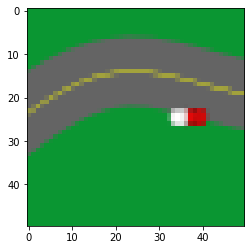

In [5]:
action = env.action_space.sample()
obs, reward, done, _ = env.step(0)

print(reward)
fig = plt.figure
plt.imshow(obs)

### DL models

In [6]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import random
import collections
import itertools
import pandas as pd
import seaborn as sns

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class QNetwork(nn.Module):
    def __init__(self, action_dim):
        super(QNetwork, self).__init__()
        
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.LeakyReLU(0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.LeakyReLU(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.LeakyReLU(0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 6 * 6, 32)
        self.relu3 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(32, action_dim)
        
    def forward(self, x):
        # Define the forward pass of the CNN
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x



In [9]:
def obs2tensor(obs):
    if not(isinstance(obs[0,0,0], np.uint8)):
        return torch.tensor(obs, dtype=torch.float32).permute(0,3,1,2).to(device)
    else:
        return torch.tensor(obs, dtype=torch.float32).unsqueeze(0).permute(0,3,1,2).to(device)

In [10]:
obstensor = obs2tensor(obs)
model = QNetwork(action_dim).to(device)

model(obstensor)

tensor([[-0.0075,  0.7625, -3.5442, -1.2941, -0.8125, -1.0014]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [11]:
class EpsilonGreedy:
    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay:float,
                 env: gym.Env,
                 q_network: torch.nn.Module):

        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:

        state = obs2tensor(state)
        if np.random.rand() > self.epsilon:
            action = self.q_network(state).argmax(dim=1).item()  
            rdm = -1
        else :
            action = self.env.action_space.sample()
            rdm = 1

        return action, rdm
        

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [12]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):

        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self):
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

In [13]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        return len(self.buffer)

In [14]:
def train_dqn2_agent(env: gym.Env,
                     q_network: torch.nn.Module,
                     target_q_network: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     loss_fn,
                     epsilon_greedy: EpsilonGreedy,
                     device: torch.device,
                     lr_scheduler,
                     num_episodes: int,
                     gamma: float,
                     batch_size: int,
                     replay_buffer,
                     target_q_network_sync_period: int,
                     delay):

    iteration = 0
    episode_reward_list = []
    

    for episode_index in tqdm(range(1, num_episodes)):
        state = env.reset()
        episode_reward = 0
        rdm = 10

        for t in itertools.count():

            # Get action, next_state and reward

            if np.abs(rdm) >= delay:
                action,rdm = epsilon_greedy(state)
            elif rdm<0:
                rdm -= 1
            elif rdm >=1:
                rdm += 1

            next_state, reward, done, _ = env.step(action)

            replay_buffer.add(state, action, reward, next_state, done)

            episode_reward += reward
            # Update the q_network weights with a batch of experiences from the buffer

            if len(replay_buffer) > batch_size:
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample(batch_size)

                # Convert to PyTorch tensors
                batch_states_tensor = obs2tensor(batch_states)
                batch_actions_tensor = torch.tensor(batch_actions, dtype=torch.long, device=device)
                batch_rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
                batch_next_states_tensor = obs2tensor(batch_next_states)
                batch_dones_tensor = torch.tensor(batch_dones, dtype=torch.float32, device=device)

                loss = loss_fn(q_network(batch_states_tensor)[range(batch_actions_tensor.size(0)), batch_actions_tensor], batch_rewards_tensor + gamma * torch.max(target_q_network(batch_next_states_tensor),axis=1).values * (1 - batch_dones_tensor))


                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                lr_scheduler.step()

            # Update the target q-network

            # Every few training steps (e.g., every 100 steps), the weights of the target network are updated with the weights of the Q-network

            if iteration % target_q_network_sync_period == 0:
                target_q_network.load_state_dict(q_network.state_dict())

            iteration += 1

            if done:
                break

            state = next_state


        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()
        print(episode_reward)
    return episode_reward_list

In [15]:
env = CarEnv(30,False)

NUMBER_OF_TRAININGS = 1
dqn2_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Instantiate required objects

    q_network = QNetwork(action_dim).to(device)
    target_q_network = QNetwork(action_dim).to(device)

    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.99, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.9, epsilon_min=0.01, epsilon_decay=0.97, env=env, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn2_agent(env,
                                           q_network,
                                           target_q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=300,
                                           gamma=0.85,
                                           batch_size=128,
                                           replay_buffer=replay_buffer,
                                           target_q_network_sync_period=50,
                                           delay=4)
    dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn2_trains_result_list[1].extend(episode_reward_list)
    dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

# Save the action-value estimation function

torch.save(q_network, "dqn2_q_network.pth")



  0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
torch.save(q_network, "dqn2_q_network.pth")

In [ ]:
episode_reward_list = train_dqn2_agent(env,
                                        q_network,
                                        target_q_network,
                                        optimizer,
                                        loss_fn,
                                        epsilon_greedy,
                                        device,
                                        lr_scheduler,
                                        num_episodes=300,
                                        gamma=0.9,
                                        batch_size=128,
                                        replay_buffer=replay_buffer,
                                        target_q_network_sync_period=30,
                                        delay = 2)
dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
dqn2_trains_result_list[1].extend(episode_reward_list)
dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

  0%|          | 0/149 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
env.close()

In [ ]:
dqn2_trains_result_df = pd.DataFrame(np.array(dqn2_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

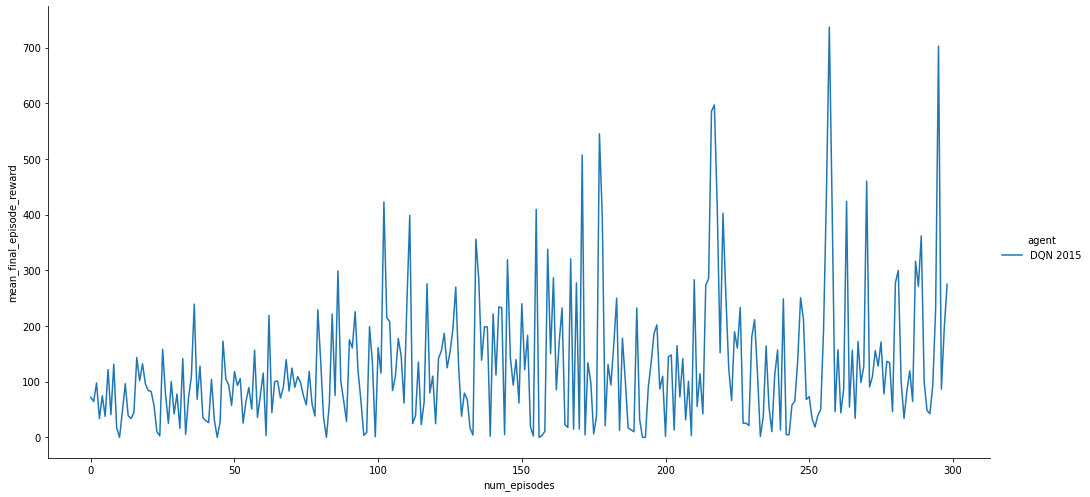

In [ ]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn2_trains_result_df,
                height=7, aspect=2);

In [ ]:
q_network = torch.load("dqn2_q_network.pth")

NameError: name 'torch' is not defined

In [ ]:
# Create an instance of the custom environment
env = CarEnv(30,evaluation=True)

# Example of using the environment
obs = env.reset()
score = 0

while True:
    obstensor = obs2tensor(obs)
    action = q_network(obstensor).argmax(dim=1)
    obs, reward, done, _ = env.step(action)
    score += reward
    if done:
        break
print(score)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\matth\AppData\Local\Temp\ipykernel_14796\973805718.py", line 11, in <cell line: 8>
    obs, reward, done, _ = env.step(action)
  File "c:\Users\matth\Documents\X\INFautonomous\Projet\environment.py", line 154, in step
  File "c:\Users\matth\Documents\X\INFautonomous\Projet\environment.py", line 207, in _get_observation
    image = pg.surfarray.array3d(self.screen)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 1992, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\matth\AppData\Local\Programs\Python\Python310\lib\sit